In [1]:
import sys
sys.path.insert(1, '/Users/ferratan/Downloads/Capstone-main/lib')

import helper_functions

In [2]:
# conda install -c huggingface transformers

Solving environment: done

## Package Plan ##

  environment location: /Users/ferratan/opt/anaconda3

  added / updated specs:
    - transformers


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    transformers-4.24.0        |             py_0         2.6 MB  huggingface
    ------------------------------------------------------------
                                           Total:         2.6 MB

The following packages will be UPDATED:

  transformers       pkgs/main/osx-64::transformers-4.18.0~ --> huggingface/noarch::transformers-4.24.0-py_0 None



transformers-4.24.0  | 2.6 MB    | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: done
Retrieving notices: ...working... done

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import transformers

from transformers import pipeline
from helper_functions import *

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', None) 

In [99]:
df = pd.read_csv('/Users/ferratan/Downloads/Capstone-main/Brands/Ferra/MossOut_hand-labeled.csv', index_col = [0])

In [100]:
#replace NaN in label columns with 0
columns = ['cost','ease of use', 'effective', 'efficient']

for column in columns:
    df[column] = df[column].replace(np.nan, int(0))

# Sentiment Analysis

In [23]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [101]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

sentiment = [None] * len(df)
index = -1
for sentence in df['review_lower']:
    index+=1
    if(index%20 == 0):
        print(index)

    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
df['sentiment_m'] = sentiment

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


# Zero-Shot Classifier

In [102]:
classifier  = pipeline("zero-shot-classification",  model = "facebook/bart-large-mnli")

In [103]:
# insert the labels you identified from above section
type = ['cost', 'efficient', 'effective', 'ease of use']

In [104]:
#setting empty values for the columns
index = -1
for label in type:
    df[label + '_m'] = -1

for j in range(len(df)):
    #counter for progress/debugging
    index+=1
    if(index%20 == 0): 
        print(index)
        
    #running the classifier on the column    
    res = classifier(
        df.iloc[j]['review_lower'],
        candidate_labels = type,
        multi_label = True
    )
    #setting the column values according to the output from the classifier ("_m" = multiclass)
    for i in range(len(res['labels'])):
        df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


In [105]:
# create a "max" column for metric purposes
df['max'] = df[['cost_m', 'efficient_m', 'effective_m', 'ease of use_m']].max(axis=1)
df.head(3)

,segment,review_id,product_name,producturl,retailer,brand,retailer_product_id,base_id,variants_flag,review_creation_date,year,month,week,review_title,review_text,review_type,price,rating,images,videos,helpful_votes,promotion_flag,review_lower,date,word_count,sentiment,efficient,effective,cost,ease of use,sentiment_m,cost_m,efficient_m,effective_m,ease of use_m,max
13020,Garden,77059,MOSS OUT! Spot Treater For Lawns & Flower Beds...,http://www.homedepot.com/p/314752274,Homedepot,MossOut,314752274,314752274,No,2022-03-18 0:00:00,2022,3,11,Vert very impressed,[This review was collected as part of a promot...,syndicated reviews,14.97,5,0,0,0,Yes,[this review was collected as part of a promot...,2022-03-18,39,Positive,1.0,1.0,0.0,0.0,Positive,0.114581,0.995088,0.998280,0.831211,0.998280
14201,Garden,80004,MOSS OUT! For Lawns 20 lb Granules,https://www.amazon.com/dp/B0015HZIT0,Amazon,MossOut,B0015HZIT0,B0015HZIT0,No,2022-04-07 0:00:00,2022,4,14,Moss wiped out!,I used this product in the middle Tennessee ar...,organic reviews,14.97,5,0,0,0,No,i used this product in the middle tennessee ar...,2022-04-07,82,Positive,1.0,1.0,0.0,0.0,Positive,0.868776,0.977322,0.998868,0.733316,0.998868
24134,Garden,140064,MOSS OUT! For Roofs & Walks 27 oz. Ready To Spray,https://www.amazon.com.com/dp/B000SKZ1QK,Amazon,MossOut,B000SKZ1QK,B000SKZ1QK,No,2022-06-03 0:00:00,2022,6,22,Works fast,Ive used this product multiple times and am am...,organic reviews,0.00,5,0,0,0,No,ive used this product multiple times and am am...,2022-06-03,25,Positive,1.0,1.0,0.0,0.0,Positive,0.417272,0.970810,0.996948,0.750271,0.996948


# Insights

In [106]:
#assign the max to its aligned type
align_list=[]
j = 0
for i in range(len(df)):
  for t in type:
    if df[t+'_m'].iloc[i] == df['max'].iloc[i]:
      # print(i)
      # print(df[t+'_m'].iloc[i])
      align_list.append(t)

df['align_type']=align_list

In [107]:
# Create Pivot table for the Heatmap
table_count = pd.pivot_table(df, values='max', index=['sentiment'], columns=['align_type'], aggfunc='count', margins=True, 
                       dropna=True, fill_value=0)
table_count

align_type,cost,ease of use,effective,efficient,All
sentiment,,,,,
Negative,11,0,0,0,11
Neutral,4,2,9,0,15
Positive,0,5,67,1,73
All,15,7,76,1,99


In [108]:
#count the percentage
table2 = table_count.div( table_count.iloc[-1,:], axis=1 ).applymap('{:.0%}'.format)
table2=table2.drop('All').drop(labels='All', axis=1)
table2

align_type,cost,ease of use,effective,efficient
sentiment,,,,
Negative,73%,0%,0%,0%
Neutral,27%,29%,12%,0%
Positive,0%,71%,88%,100%


In [109]:
#Drop "ALL" column and row
table_count=table_count.drop('All').drop(labels='All', axis=1)

#reshape results
results=np.asarray(table2)

#check results
results

array([['73%', '0%', '0%', '0%'],
       ['27%', '29%', '12%', '0%'],
       ['0%', '71%', '88%', '100%']], dtype=object)

<Figure size 864x360 with 0 Axes>

[Text(0.5, 17.5, ''), Text(80.5, 0.5, '')]

[Text(0.5, 17.5, ''), Text(80.5, 0.5, '')]

[Text(0.5, 17.5, ''), Text(80.5, 0.5, '')]

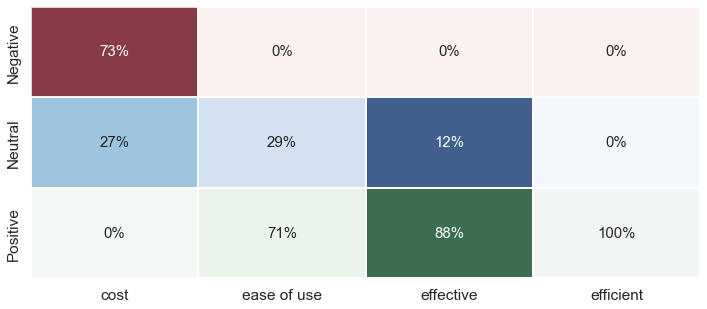

In [110]:
# Heatmap

plt.figure(figsize=(12, 5))
sns.set(font_scale=1.4)
# Reds
data1 = table_count.copy()
data1.loc['Negative'] = float('nan')
data1.loc['Neutral'] = float('nan')
ax=sns.heatmap(data1, annot=results, cmap="Greens",alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# Blue
data2 = table_count.copy()
data2.loc['Negative'] = float('nan')
data2.loc['Positive'] = float('nan')
ax=sns.heatmap(data2, annot=results, cmap="Blues", alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")
# Greens
data3 = table_count.copy()
data3.loc['Positive'] = float('nan')
data3.loc['Neutral'] = float('nan')
ax=sns.heatmap(data3, annot=results, cmap="Reds", alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

In [111]:
# treemap

from collections import defaultdict
import plotly.express as px

data =  pd.DataFrame.from_dict(df)
fig = px.treemap(data, path=['sentiment_m', 'align_type'])

fig.data[0].textinfo = 'label+text+value'
fig.data[0]['textfont']['color'] = "white"
fig.data[0]['textfont']['size'] = 15
fig.data[0].textposition = 'middle center'

fig.layout.hovermode = False

fig.show()

# For 5 start rating reviews

In [112]:
df_5 = df[df['rating'] == 5]

Text(0.5, 1.0, 'Top 10 Products with 5 Ratings')

<AxesSubplot:title={'center':'Top 10 Products with 5 Ratings'}, xlabel='count', ylabel='product_name'>

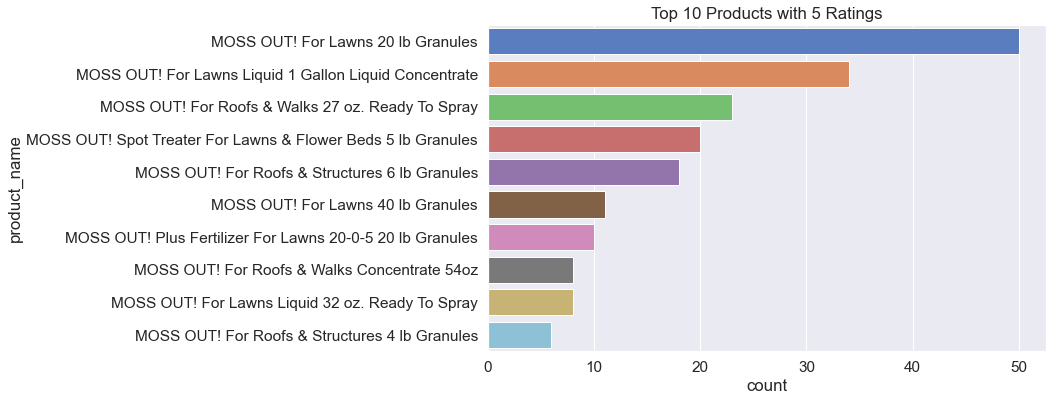

In [113]:
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
plt.title('Top 10 Products with 5 Ratings');
sns.countplot(y = 'product_name', data = df_5, order = df_5['product_name'].value_counts()[0:10].index, palette = "muted")
#plt.savefig('figs/negative_homedepot', bbox_inches = 'tight');

# N-gram

In [56]:
from collections import defaultdict
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [58]:
# pip install wordcloud

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 160 kB 3.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [114]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in df_5["review_lower"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

/Users/ferratan/opt/anaconda3/lib/python3.9/site-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Heatmap

In [120]:
# Create Pivot table for the Heatmap
table_count = pd.pivot_table(df_5, values='max', index=['sentiment'], columns=['align_type'], aggfunc='count', margins=True, 
                       dropna=True, fill_value=0)

#count the percentage
table2 = table_count.div( table_count.iloc[-1,:], axis=1 ).applymap('{:.0%}'.format)
table2=table2.drop('All').drop(labels='All', axis=1)


#Drop "ALL" column and row
table_count=table_count.drop('All').drop(labels='All', axis=1)

#reshape results
results=np.asarray(table2)

align_type,ease of use,effective,efficient
sentiment,,,
Neutral,0,1,0
Positive,4,51,1


<Figure size 864x360 with 0 Axes>

[Text(0.5, 17.5, ''), Text(80.5, 0.5, '')]

[Text(0.5, 17.5, ''), Text(80.5, 0.5, '')]

[Text(0.5, 17.5, ''), Text(80.5, 0.5, '')]

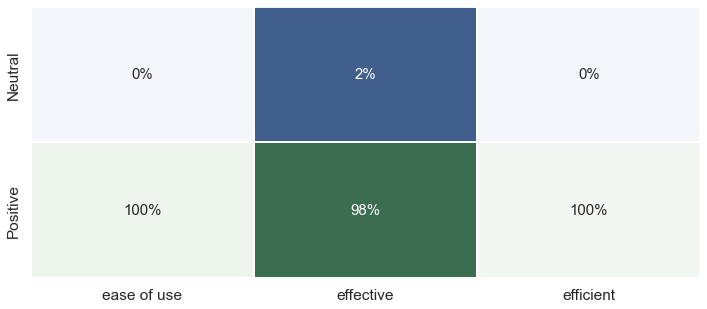

In [126]:
# Heatmap

plt.figure(figsize=(12, 5))
sns.set(font_scale=1.4)
# Reds
data1 = table_count.copy()
data1.loc['Neutral'] = float('nan')
ax=sns.heatmap(data1, annot=results, cmap="Greens",alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# Blue
data2 = table_count.copy()
data2.loc['Positive'] = float('nan')
ax=sns.heatmap(data2, annot=results, cmap="Blues", alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")
# Greens
data3 = table_count.copy()
data3.loc['Positive'] = float('nan')
data3.loc['Neutral'] = float('nan')
ax=sns.heatmap(data3, annot=results, cmap="Reds", alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# For 1 Star Rated Reviews

In [66]:
df_1 = df[df['rating'] == 1]

Text(0.5, 1.0, 'Top 10 Products with 1 Ratings')

<AxesSubplot:title={'center':'Top 10 Products with 1 Ratings'}, xlabel='count', ylabel='product_name'>

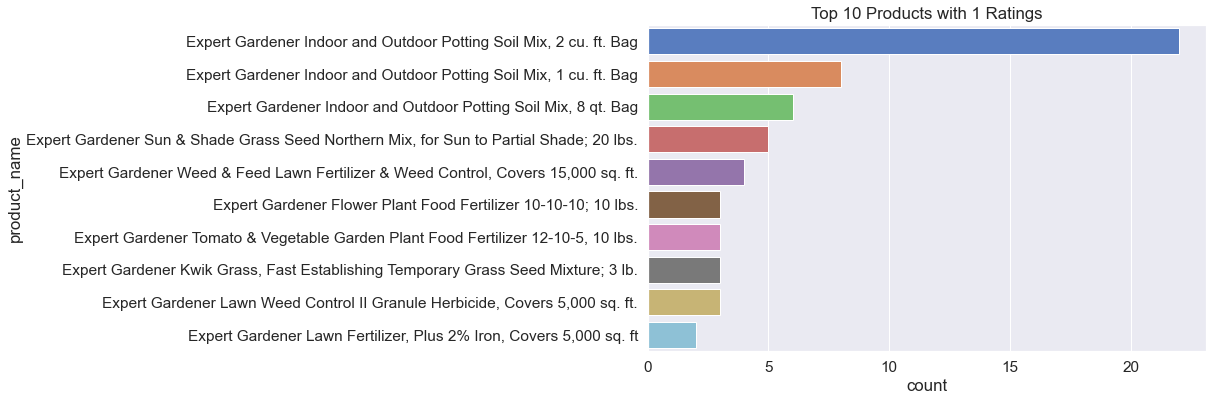

In [67]:
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
plt.title('Top 10 Products with 1 Ratings');
sns.countplot(y = 'product_name', data = df_1, order = df_1['product_name'].value_counts()[0:10].index, palette = "muted")
#plt.savefig('figs/negative_homedepot', bbox_inches = 'tight');

In [127]:
## Get the bar chart from 1 rated reviews ##
freq_dict = defaultdict(int)
for sent in df_1["review_lower"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

/Users/ferratan/opt/anaconda3/lib/python3.9/site-packages/plotly/tools.py:461: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [128]:
# Create Pivot table for the Heatmap
table_count = pd.pivot_table(df_1, values='max', index=['sentiment'], columns=['align_type'], aggfunc='count', margins=True, 
                       dropna=True, fill_value=0)

#count the percentage
table2 = table_count.div( table_count.iloc[-1,:], axis=1 ).applymap('{:.0%}'.format)
table2=table2.drop('All').drop(labels='All', axis=1)


#Drop "ALL" column and row
table_count=table_count.drop('All').drop(labels='All', axis=1)

#reshape results
results=np.asarray(table2)

# Heatmap

plt.figure(figsize=(12, 5))
sns.set(font_scale=1.4)
# Reds
data1 = table_count.copy()
data1.loc['Negative'] = float('nan')
data1.loc['Neutral'] = float('nan')
ax=sns.heatmap(data1, annot=results, cmap="Greens",alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# Blue
data2 = table_count.copy()
data2.loc['Negative'] = float('nan')
ax=sns.heatmap(data2, annot=results, cmap="Blues", alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# Greens
data3 = table_count.copy()
data3.loc['Neutral'] = float('nan')
ax=sns.heatmap(data3, annot=results, cmap="Reds", alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

In [74]:
df.to_csv('evaluation_MossOut.csv')